For the EDA of the datasets, they need to be preprocessed. Therefore, run 4_run_paper_benchmark.py with the only model "SeasAgg" and the only train_len "168". This is fast and afterwards, run this notebook.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [2]:
path_to_processed = "/home/dev/projects/data/processed/"
path_to_save_data_plots = "/home/dev/projects/data/outputs/benchmark/data_plots/"
image_format = "png" #png or pdf


In [3]:
dataset = "LP17_11"
signal = "load"
from_unit = "kWh"
to_unit = "kWh"

In [4]:
df = pd.read_parquet(path_to_processed + "{dataset}/processed.parquet".format(dataset=dataset))
df

,signal_id,date,w_cosine,y_cosine,d_cosine,holiday,m_cosine,w_sine,m_sine,d_sine,holiday_or_weekend,weekend,y_sine,power
0,load,2016-12-31 23:00:00+00:00,-0.222521,1.000000,0.965926,0,1.00000,-0.974928,-2.449294e-16,-0.258819,1,1,-2.449294e-16,0.55000
1,load,2017-01-01 00:00:00+00:00,0.623490,0.999852,1.000000,1,0.97953,-0.781831,2.012985e-01,0.000000,1,1,1.721336e-02,0.63600
2,load,2017-01-01 01:00:00+00:00,0.623490,0.999852,0.965926,1,0.97953,-0.781831,2.012985e-01,0.258819,1,1,1.721336e-02,0.55200
3,load,2017-01-01 02:00:00+00:00,0.623490,0.999852,0.866025,1,0.97953,-0.781831,2.012985e-01,0.500000,1,1,1.721336e-02,0.55275
4,load,2017-01-01 03:00:00+00:00,0.623490,0.999852,0.707107,1,0.97953,-0.781831,2.012985e-01,0.707107,1,1,1.721336e-02,0.69450
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8756,load,2017-12-31 19:00:00+00:00,0.623490,1.000000,0.258819,0,1.00000,-0.781831,-2.449294e-16,-0.965926,1,1,6.432491e-16,0.00000
8757,load,2017-12-31 20:00:00+00:00,0.623490,1.000000,0.500000,0,1.00000,-0.781831,-2.449294e-16,-0.866025,1,1,6.432491e-16,0.00000
8758,load,2017-12-31 21:00:00+00:00,0.623490,1.000000,0.707107,0,1.00000,-0.781831,-2.449294e-16,-0.707107,1,1,6.432491e-16,0.00000
8759,load,2017-12-31 22:00:00+00:00,0.623490,1.000000,0.866025,0,1.00000,-0.781831,-2.449294e-16,-0.500000,1,1,6.432491e-16,0.00000


In [5]:
if (from_unit == "W")&(to_unit=="kW"):
    df["power"] = df["power"]/1000

In [6]:
min_date = df.date.min()
max_date = df.date.max()
weeks = round((max_date - min_date).days/7)
print("Data available from {min} to {max}, which is {weeks} weeks".format(min=min_date, max= max_date, weeks=weeks))

Data available from 2016-12-31 23:00:00+00:00 to 2017-12-31 23:00:00+00:00, which is 52 weeks


Plot overall dataset

In [7]:
df_plot = df.copy()
df_plot.set_index('date', inplace=True)
df_plot.loc[df_plot["power"] < 0, "power"] = 0

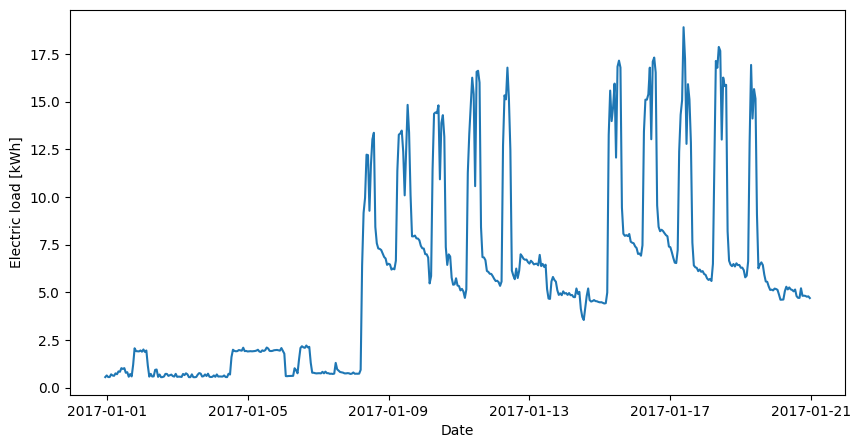

In [8]:
df_plot_here = df_plot[df_plot.index < "2017-01-21"]
# Plot the time series
plt.figure(figsize=(10, 5))
plt.plot(df_plot_here.index, df_plot_here.power)
plt.xlabel('Date')
plt.ylabel(f'Electric load [{to_unit}]')
plt.savefig(f"{path_to_save_data_plots}{dataset}.{image_format}")
plt.show()

Plot mean week

In [9]:
def plot_distribution_weekly_power(df, scale=True):
    for week in np.unique(df.week):
        weekly = df[df.week == week]
        weekly = weekly.set_index("weekday")
        if scale:
            weekly.power /= weekly.power.mean()
            weekly.power = weekly.power.fillna(0) # If devision by zero
        weekly.power.plot(color='grey', alpha=0.5)
    
    overall_power = df.groupby(by='weekday').power.mean()
    if scale:
        overall_power /= overall_power.mean()
    overall_power.plot(color='r', linestyle=':')

In [10]:
df_aggregated = pd.DataFrame(df_plot["power"].resample('D').sum())
df_aggregated['weekday'] = df_aggregated.index.weekday
df_aggregated['week'] = df_aggregated.index.isocalendar().week
df_aggregated['year'] = df_aggregated.index.year
df_aggregated['week'] = df_aggregated["week"].astype(str) + "_" + df_aggregated["year"].astype(str)

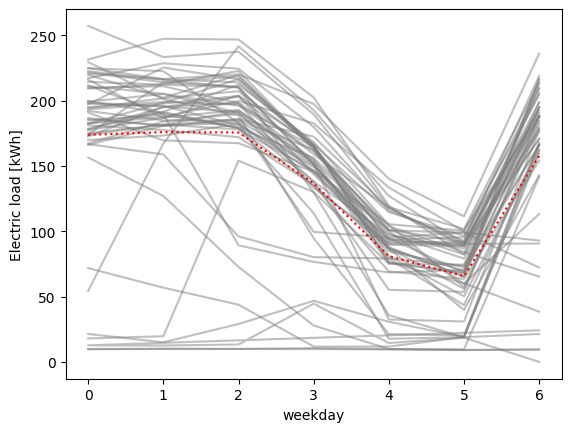

In [11]:
plot_distribution_weekly_power(df_aggregated, scale=False)
#plt.ylim(0,3)
plt.ylabel(f'Electric load [{to_unit}]')
plt.savefig(f"{path_to_save_data_plots}{dataset}_avg_week.{image_format}")

Plot mean weekday and weekend day

In [12]:
def plot_distribution_daily_power(df, scale=True):
    for day in np.unique(df.index.date):
        daily = df[df.index.date == day]
        daily = daily.set_index('time')
        if scale:
            daily /= daily.mean()
            daily = daily.fillna(0) # If devision by zero
        daily.power.plot(color='grey', alpha=0.05)
    
    overall_power = df.groupby(by='time').power.mean()
    if scale:
        overall_power /= overall_power.mean()
    overall_power.plot(color='r', linestyle=':')

In [13]:
df_daily = df_plot

In [14]:
df_daily["time"] = df_daily.index.time
df_daily = df_daily[["time", "power"]]

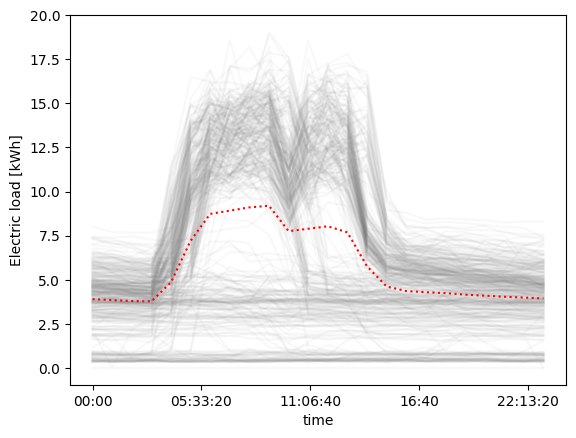

In [15]:
plot_distribution_daily_power(df_daily, scale=False)
#plt.ylim(0,6)
plt.ylabel(f'Electric load [{to_unit}]')
plt.savefig(f"{path_to_save_data_plots}{dataset}_avg_day.{image_format}")

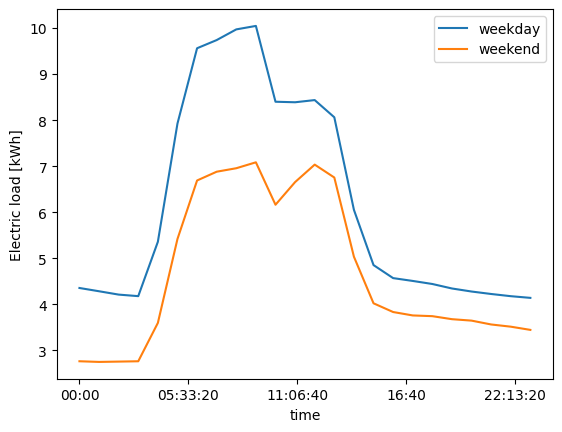

In [16]:
data = df_daily[df_daily.index.weekday < 5]
data.groupby('time').power.mean().plot(label='weekday')

data = df_daily[df_daily.index.weekday >=5 ]
data.groupby('time').power.mean().plot(label='weekend')

plt.legend()
plt.ylabel(f'Electric load [{to_unit}]')
plt.savefig(f"{path_to_save_data_plots}{dataset}_avg_day_weekday_weekend.{image_format}")

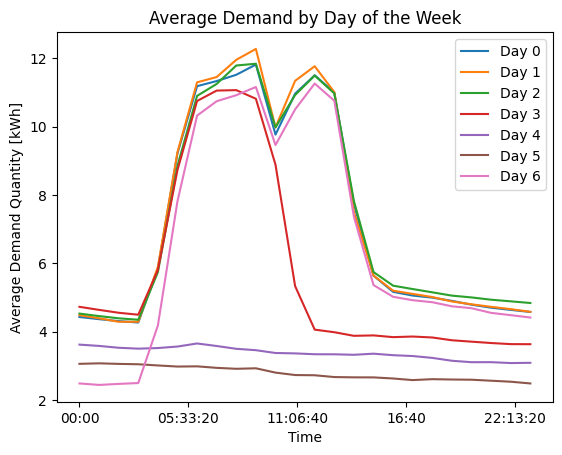

In [17]:
for day in range(7):
    data = df_daily[df_daily.index.weekday == day]
    ax = data.groupby('time').power.mean().plot(label=f'Day {day}')
    
plt.legend()  # Show the legend
plt.xlabel('Time')  # X-axis label
plt.ylabel(f'Average Demand Quantity [{to_unit}]')  # Y-axis label
plt.title('Average Demand by Day of the Week')  # Title of the plot
plt.show()

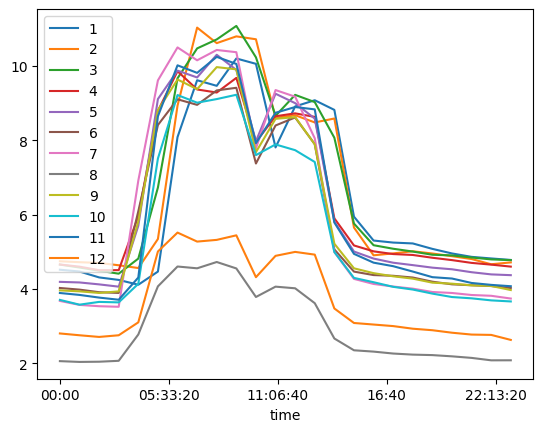

In [18]:
for month in range(1, 13):
    data = df_daily[df_daily.index.month == month]
    data.groupby('time').power.mean().plot(label=str(month))
plt.legend()

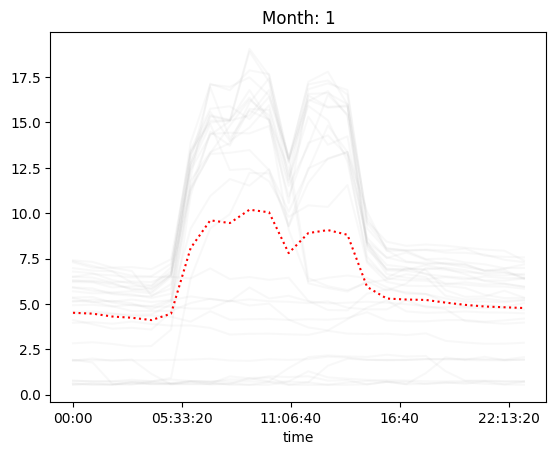

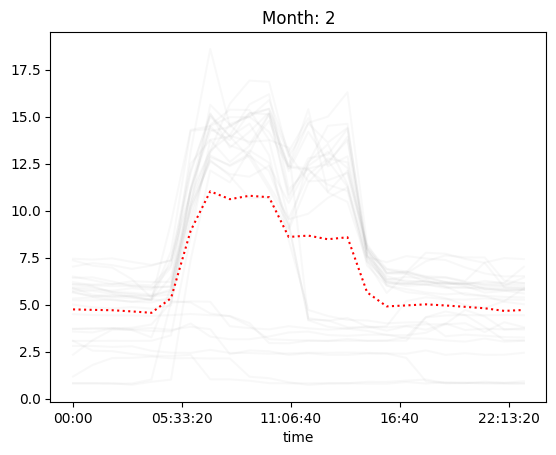

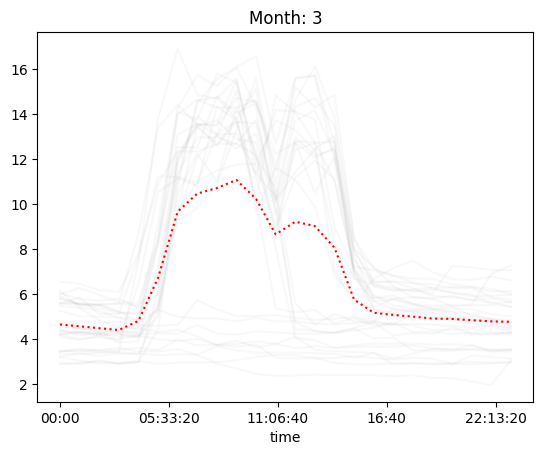

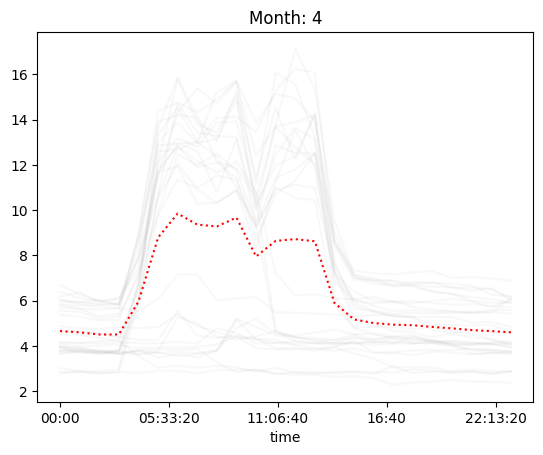

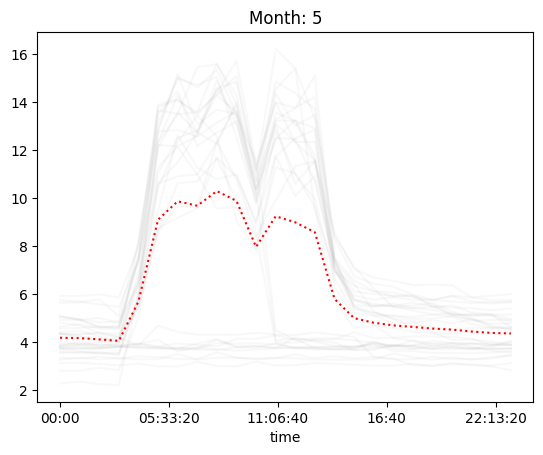

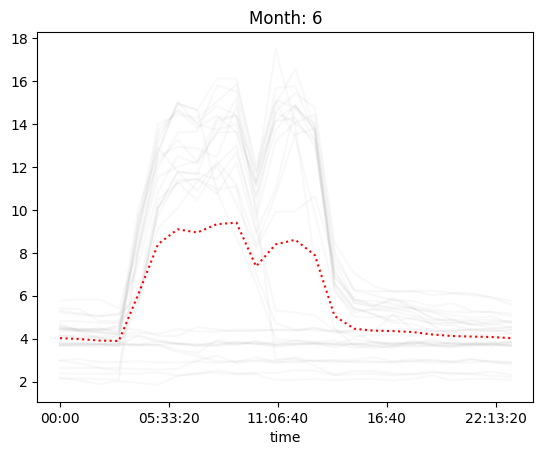

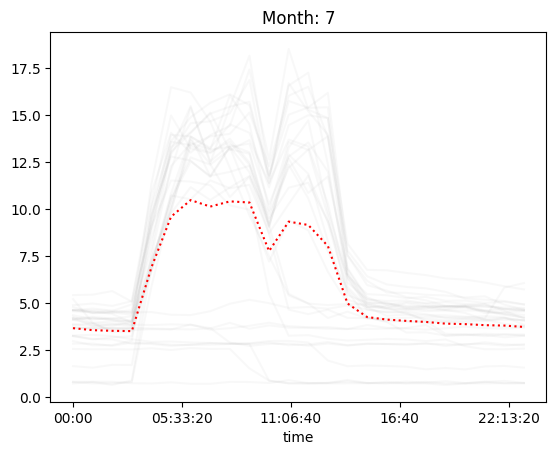

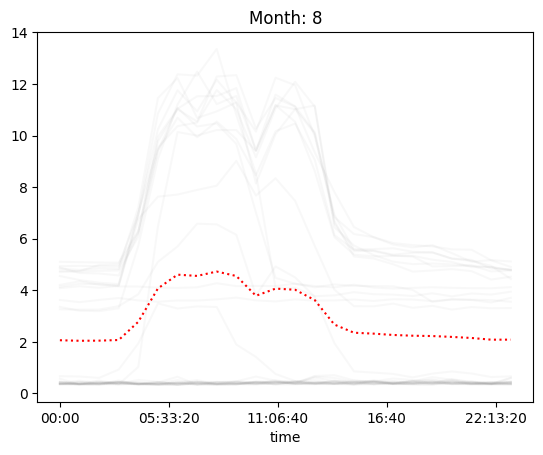

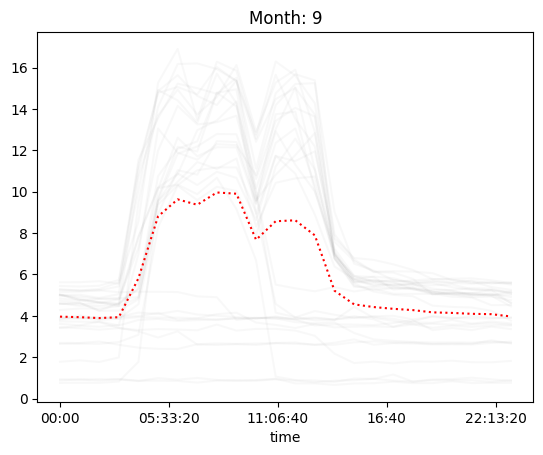

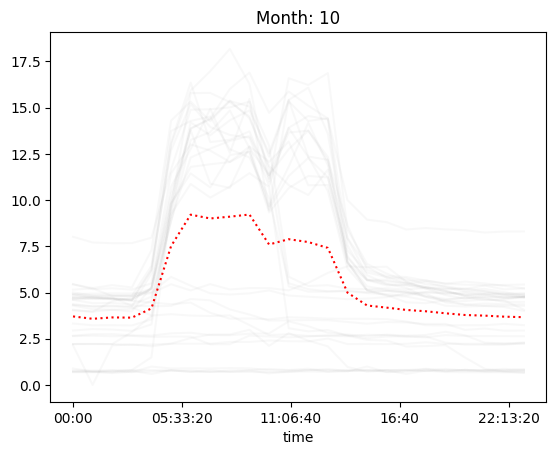

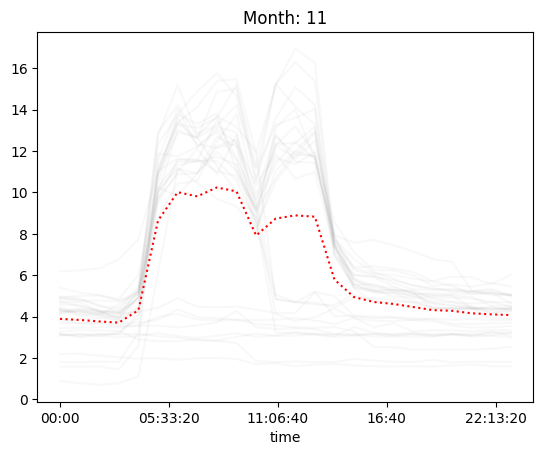

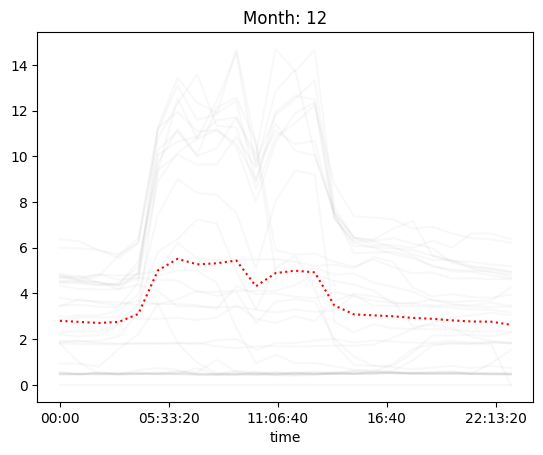

In [19]:
for month in range(1, 13):
    data = df_daily[df_daily.index.month == month]

    plot_distribution_daily_power(data, scale=False)
    plt.title(f'Month: {month}')
    plt.show()
    plt.close()

Check correlation nfl and weekend and holidays

In [20]:
if signal == "load":
    for var in ["holiday", "weekend"]:
        correlation = df_plot['power'].corr(df_plot[var])
        print("Correlation to {}: {}".format(var, correlation.round(2)))

Correlation to holiday: -0.07
Correlation to weekend: -0.17


Check correlation pv production and weather variables

In [21]:
if signal == "pv":
    for var in ["temperature", "humidity", "cloud_coverage", "wind_speed", "boolean_is_day"]:
        correlation = df_plot['power'].corr(df_plot[var])
        print("Correlation to {}: {}".format(var, correlation.round(2)))